In [2]:
import zipfile
with zipfile.ZipFile('archive-2.zip', 'r') as zip_ref:
    zip_ref.extracta----00--0--0=-=--=-ll('.')

FileNotFoundError: ignored

In [3]:
import os

print("List of extracted files- ")

#loop to print necessary files
p=os.path.join(os.getcwd())

for item in os.listdir(path=p):
        print(item)

List of extracted files- 
.config
.ipynb_checkpoints
test2_output.txt
real_and_fake_face
train_data.csv
test1_output.txt
test_data.csv
real_vs_fake
sample_data


In [4]:
%pwd

'/content'

## Error Level Analysis

In [5]:
from PIL import Image, ImageChops, ImageEnhance

def convert_to_ela_image(path, output_folder):
  filename = path

  img = Image.open(filename).convert('RGB')
  resized_image = img.resize((224, 224))
  temp_image_path = os.path.join(output_folder, "temp.jpg")
  img.save(temp_image_path, 'JPEG', quality=95)

  resave_img = Image.open(temp_image_path)

  ela_img = ImageChops.difference(img, resave_img)
  extrema = ela_img.getextrema()
  diff = max([ex[1] for ex in extrema])

  scale = 255.0 / diff
  ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)

  ela_output_path = os.path.join(output_folder, os.path.basename(path).replace(".jpg", "_ela.jpg"))
  ela_img.save(ela_output_path)

  os.remove(temp_image_path)

real_img_path = '/content/real_vs_fake/real-vs-fake/train/real'
fake_img_path = '/content/real_vs_fake/real-vs-fake/train/fake'
ela_real_output = '/content/real_vs_fake/real-vs-fake/train/ela_real'
ela_fake_output = '/content/real_vs_fake/real-vs-fake/train/ela_fake'

os.makedirs(ela_real_output, exist_ok=True)
os.makedirs(ela_fake_output, exist_ok=True)

i = 0
for img in os.listdir(real_img_path):
  if i < 1000:
    #print(im.shape)
    if img.endswith(".jpg"):
      img_path = os.path.join(real_img_path, img)
      convert_to_ela_image(img_path, ela_real_output)
  i += 1

j = 0
for img in os.listdir(fake_img_path):
  if j < 1000:
    #print(im.shape)
    if img.endswith(".jpg"):
      img_path = os.path.join(fake_img_path, img)
      convert_to_ela_image(img_path, ela_fake_output)
  j += 1


In [31]:
real_img_path = '/content/real_vs_fake/real-vs-fake/test/real'
fake_img_path = '/content/real_vs_fake/real-vs-fake/test/fake'
ela_real_output = '/content/real_vs_fake/real-vs-fake/test/ela_real'
ela_fake_output = '/content/real_vs_fake/real-vs-fake/test/ela_fake'

os.makedirs(ela_real_output, exist_ok=True)
os.makedirs(ela_fake_output, exist_ok=True)

i = 0
for img in os.listdir(real_img_path):
  if i < 1000:
    #print(im.shape)
    if img.endswith(".jpg"):
      img_path = os.path.join(real_img_path, img)
      convert_to_ela_image(img_path, ela_real_output)
  i += 1

j = 0
for img in os.listdir(fake_img_path):
  if j < 1000:
    #print(im.shape)
    if img.endswith(".jpg"):
      img_path = os.path.join(fake_img_path, img)
      convert_to_ela_image(img_path, ela_fake_output)
  j += 1


## CNN

In [7]:
!pip install torch torchvision Pillow

In [8]:
!pip install matplotlib seaborn scikit-learn

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [10]:
def get_confusion_matrix_svm(y_test, svm_pred, label):
  cm_svm = confusion_matrix(y_test, svm_pred, labels=label)

  TP_svm = cm_svm[1, 1]
  FP_svm = cm_svm[0, 1]
  TN_svm = cm_svm[0, 0]
  FN_svm = cm_svm[1, 0]

  # Accuracy
  acc_svm = ((TN_svm + TP_svm) / (TP_svm + FN_svm + TN_svm + FP_svm)) * 100

  # Recall
  rec_svm = (TP_svm / (FN_svm + TP_svm)) * 100

  # Precision
  pre_svm = (TP_svm / (FP_svm + TP_svm)) * 100

  # F1 Score
  f1_score_svm = (TP_svm / (TP_svm + 0.5 * (FP_svm + FN_svm))) * 100


  return cm_svm, acc_svm, rec_svm, pre_svm, f1_score_svm

def get_confusion_matrix_knn(y_test, knn_pred, label):
  cm_knn = confusion_matrix(y_test, knn_pred, labels=label)

  TP_knn = cm_knn[1, 1]
  FP_knn = cm_knn[0, 1]
  TN_knn = cm_knn[0, 0]
  FN_knn = cm_knn[1, 0]

  # Accuracy
  acc_knn = ((TN_knn + TP_knn) / (TP_knn + FN_knn + TN_knn + FP_knn)) * 100

  # Recall
  rec_knn = (TP_knn / (FN_knn + TP_knn)) * 100

  # Precision
  pre_knn = (TP_knn / (FP_knn + TP_knn)) * 100

  # F1 Score
  f1_score_knn = (TP_knn / (TP_knn + 0.5 * (FP_knn + FN_knn))) * 100

  return cm_knn, acc_knn, rec_knn, pre_knn, f1_score_knn

In [11]:
def plot_metrics_svm(accuracy, recall, precision, f1_score):
    labels = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
    values = [accuracy, recall, precision, f1_score]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.bar(labels, values, color=['orange', 'yellow', 'green', 'red'])
    for i in range(len(labels)):
        plt.text(i, round(values[i],2), round(values[i],2), ha = 'center')

    plt.xlim(0, 4)
    plt.ylim(0, 100)
    plt.title('SVM')
    plt.ylabel('Metric Value')

def plot_metrics_knn(accuracy, recall, precision, f1_score):
    labels = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
    values = [accuracy, recall, precision, f1_score]

    plt.subplot(1, 2, 2)
    plt.bar(labels, values, color=['orange', 'yellow', 'green', 'red'])
    for i in range(len(labels)):
        plt.text(i, round(values[i],2), round(values[i],2), ha = 'center')

    plt.xlim(0, 4)
    plt.ylim(0, 100)
    plt.title('KNN')
    plt.ylabel('Metric Value')
    plt.show()

In [12]:
def plot_cm(cm_svm, cm_knn):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.title("SVM")
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')

  plt.subplot(1, 2, 2)
  sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.title('KNN')
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')

  plt.show()

### ResNet

In [13]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
def extract_deep_features_resnet(ela_img_path):
  ela_img = Image.open(ela_img_path).convert('RGB')

  preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(ela_img)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

  with torch.no_grad():
      features = model(input_batch)

  return features


deep_features_list_resnet_train = []
labels_list_resnet_train = []

for img in os.listdir(ela_real_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_real_output, img)
    deep_features = extract_deep_features_resnet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_resnet_train.append(deep_features_cpu.numpy().flatten())
    labels_list_resnet_train.append(0)

for img in os.listdir(ela_fake_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_fake_output, img)
    deep_features = extract_deep_features_resnet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_resnet_train.append(deep_features_cpu.numpy().flatten())
    labels_list_resnet_train.append(1)

deep_features_list_resnet_test = []
labels_list_resnet_test = []

for img in os.listdir(ela_real_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_real_output, img)
    deep_features = extract_deep_features_resnet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_resnet_test.append(deep_features_cpu.numpy().flatten())
    labels_list_resnet_test.append(0)

for img in os.listdir(ela_fake_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_fake_output, img)
    deep_features = extract_deep_features_resnet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_resnet_test.append(deep_features_cpu.numpy().flatten())
    labels_list_resnet_test.append(1)

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(deep_features_list_resnet, labels_list_resnet, test_size=0.2, random_state=42)
X_train = deep_features_list_resnet_train
X_test = deep_features_list_resnet_test
y_train = labels_list_resnet_train
y_test = labels_list_resnet_test

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Classifier with specified hyperparameters
svm_classifier = SVC(kernel='rbf', C=2.4, gamma='scale')
svm_classifier.fit(X_train_scaled, y_train)

# KNN Classifier with specified number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=881, metric='correlation')
knn_classifier.fit(X_train_scaled, y_train)

# Predictions
svm_predictions = svm_classifier.predict(X_test_scaled)
knn_predictions = knn_classifier.predict(X_test_scaled)

# Evaluate the classifiers
svm_accuracy = accuracy_score(y_test, svm_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)

# Display results
print("SVM Accuracy:", round(svm_accuracy * 100, 2), "%")
print("KNN Accuracy:", round(knn_accuracy * 100, 2), "%")

SVM Accuracy: 89.1 %
KNN Accuracy: 63.7 %


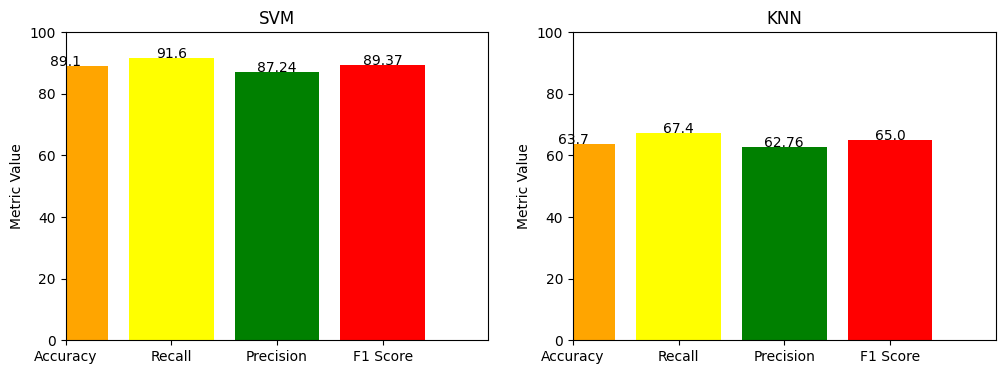

In [17]:
cm_svm, ACC_svm, REC_svm, PRE_svm, F1_SCORE_svm = get_confusion_matrix_svm(y_test, svm_predictions, svm_classifier.classes_)
cm_knn, ACC_knn, REC_knn, PRE_knn, F1_SCORE_knn = get_confusion_matrix_knn(y_test, knn_predictions, knn_classifier.classes_)

plot_metrics_svm(ACC_svm, REC_svm, PRE_svm, F1_SCORE_svm)
plot_metrics_knn(ACC_knn, REC_knn, PRE_knn, F1_SCORE_knn)

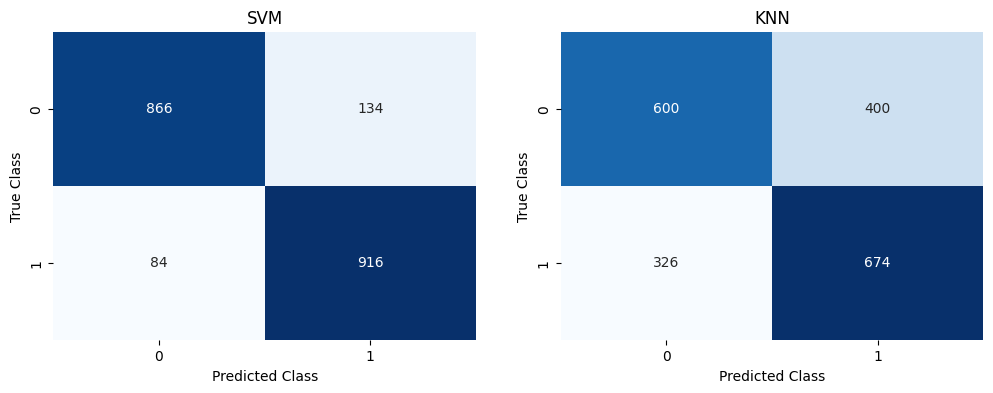

In [18]:
plot_cm(cm_svm, cm_knn)

### GoogleNet

In [19]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [20]:
def extract_deep_features_googlenet(ela_img_path):
  ela_img = Image.open(ela_img_path).convert('RGB')

  preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(ela_img)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

  with torch.no_grad():
      features = model(input_batch)

  return features



deep_features_list_googlenet_train = []
labels_list_googlenet_train = []

for img in os.listdir(ela_real_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_real_output, img)
    deep_features = extract_deep_features_googlenet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_googlenet_train.append(deep_features_cpu.numpy().flatten())
    labels_list_googlenet_train.append(0)

for img in os.listdir(ela_fake_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_fake_output, img)
    deep_features = extract_deep_features_googlenet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_googlenet_train.append(deep_features_cpu.numpy().flatten())
    labels_list_googlenet_train.append(1)

deep_features_list_googlenet_test = []
labels_list_googlenet_test = []

for img in os.listdir(ela_real_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_real_output, img)
    deep_features = extract_deep_features_googlenet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_googlenet_test.append(deep_features_cpu.numpy().flatten())
    labels_list_googlenet_test.append(0)

for img in os.listdir(ela_fake_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_fake_output, img)
    deep_features = extract_deep_features_googlenet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_googlenet_test.append(deep_features_cpu.numpy().flatten())
    labels_list_googlenet_test.append(1)

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(deep_features_list_googlenet, labels_list_googlenet, test_size=0.2, random_state=42)
X_train = deep_features_list_googlenet_train
X_test = deep_features_list_googlenet_test
y_train = labels_list_googlenet_train
y_test = labels_list_googlenet_test

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Classifier with specified hyperparameters
svm_classifier = SVC(kernel='rbf', C=0.4, gamma='scale')
svm_classifier.fit(X_train_scaled, y_train)

# KNN Classifier with specified number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=154, metric='correlation')
knn_classifier.fit(X_train_scaled, y_train)

# Predictions
svm_predictions = svm_classifier.predict(X_test_scaled)
knn_predictions = knn_classifier.predict(X_test_scaled)

# Evaluate the classifiers
svm_accuracy = accuracy_score(y_test, svm_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)

# Display results
print("SVM Accuracy:", round(svm_accuracy * 100, 2), "%")
print("KNN Accuracy:", round(knn_accuracy * 100, 2), "%")

SVM Accuracy: 72.45 %
KNN Accuracy: 64.65 %


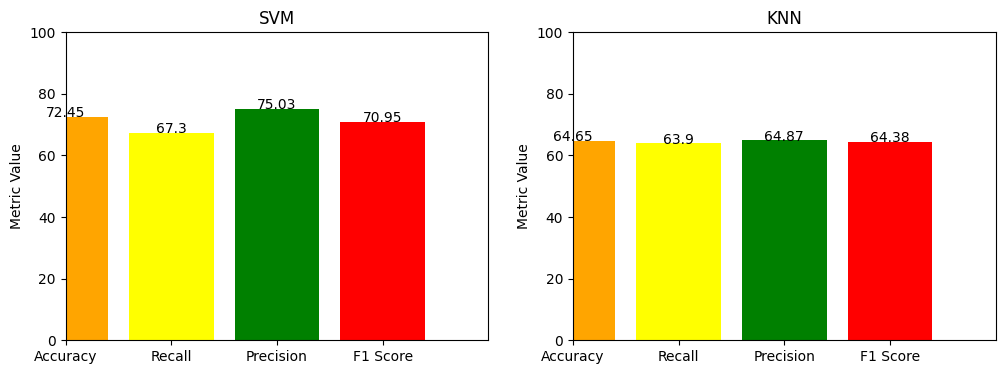

In [23]:
cm_svm, ACC_svm, REC_svm, PRE_svm, F1_SCORE_svm = get_confusion_matrix_svm(y_test, svm_predictions, svm_classifier.classes_)
cm_knn, ACC_knn, REC_knn, PRE_knn, F1_SCORE_knn = get_confusion_matrix_knn(y_test, knn_predictions, knn_classifier.classes_)

plot_metrics_svm(ACC_svm, REC_svm, PRE_svm, F1_SCORE_svm)
plot_metrics_knn(ACC_knn, REC_knn, PRE_knn, F1_SCORE_knn)

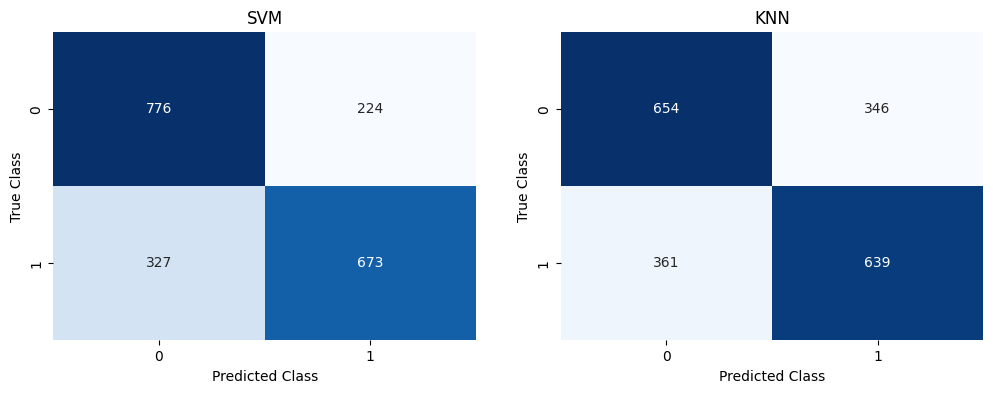

In [24]:
plot_cm(cm_svm, cm_knn)

### SqueezeNet

In [25]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [26]:
def extract_deep_features_squeezenet(ela_img_path):
  ela_img = Image.open(ela_img_path).convert('RGB')

  preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(ela_img)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

  with torch.no_grad():
      features = model(input_batch)

  return features


deep_features_list_squeezenet_train = []
labels_list_squeezenet_train = []

for img in os.listdir(ela_real_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_real_output, img)
    deep_features = extract_deep_features_squeezenet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_squeezenet_train.append(deep_features_cpu.numpy().flatten())
    labels_list_squeezenet_train.append(0)

for img in os.listdir(ela_fake_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_fake_output, img)
    deep_features = extract_deep_features_squeezenet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_squeezenet_train.append(deep_features_cpu.numpy().flatten())
    labels_list_squeezenet_train.append(1)

deep_features_list_squeezenet_test = []
labels_list_squeezenet_test = []

for img in os.listdir(ela_real_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_real_output, img)
    deep_features = extract_deep_features_squeezenet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_squeezenet_test.append(deep_features_cpu.numpy().flatten())
    labels_list_squeezenet_test.append(0)

for img in os.listdir(ela_fake_output):
  if img.endswith(".jpg"):
    ela_img_path = os.path.join(ela_fake_output, img)
    deep_features = extract_deep_features_squeezenet(ela_img_path)
    deep_features_cpu = deep_features.cpu()
    deep_features_list_squeezenet_test.append(deep_features_cpu.numpy().flatten())
    labels_list_squeezenet_test.append(1)

In [27]:
# X_train, X_test, y_train, y_test = train_test_split(deep_features_list_squeezenet, labels_list_squeezenet, test_size=0.2, random_state=42)
X_train = deep_features_list_squeezenet_train
X_test = deep_features_list_squeezenet_test
y_train = labels_list_squeezenet_train
y_test = labels_list_squeezenet_test

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Classifier with specified hyperparameters
svm_classifier = SVC(kernel='rbf', C=0.4, gamma='scale')
svm_classifier.fit(X_train_scaled, y_train)

# KNN Classifier with specified number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=154, metric='correlation')
knn_classifier.fit(X_train_scaled, y_train)

# Predictions
svm_predictions = svm_classifier.predict(X_test_scaled)
knn_predictions = knn_classifier.predict(X_test_scaled)

# Evaluate the classifiers
svm_accuracy = accuracy_score(y_test, svm_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)

# Display results
print("SVM Accuracy:", round(svm_accuracy * 100, 2), "%")
print("KNN Accuracy:", round(knn_accuracy * 100, 2), "%")

SVM Accuracy: 70.0 %
KNN Accuracy: 64.5 %


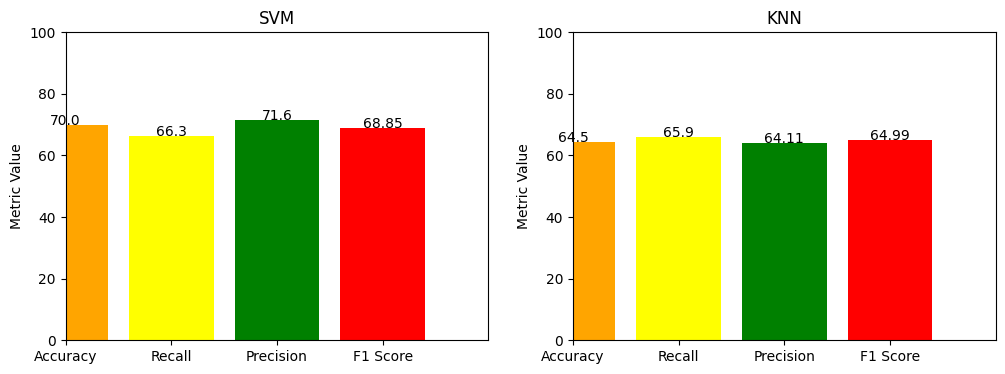

In [29]:
cm_svm, ACC_svm, REC_svm, PRE_svm, F1_SCORE_svm = get_confusion_matrix_svm(y_test, svm_predictions, svm_classifier.classes_)
cm_knn, ACC_knn, REC_knn, PRE_knn, F1_SCORE_knn = get_confusion_matrix_knn(y_test, knn_predictions, knn_classifier.classes_)

plot_metrics_svm(ACC_svm, REC_svm, PRE_svm, F1_SCORE_svm)
plot_metrics_knn(ACC_knn, REC_knn, PRE_knn, F1_SCORE_knn)

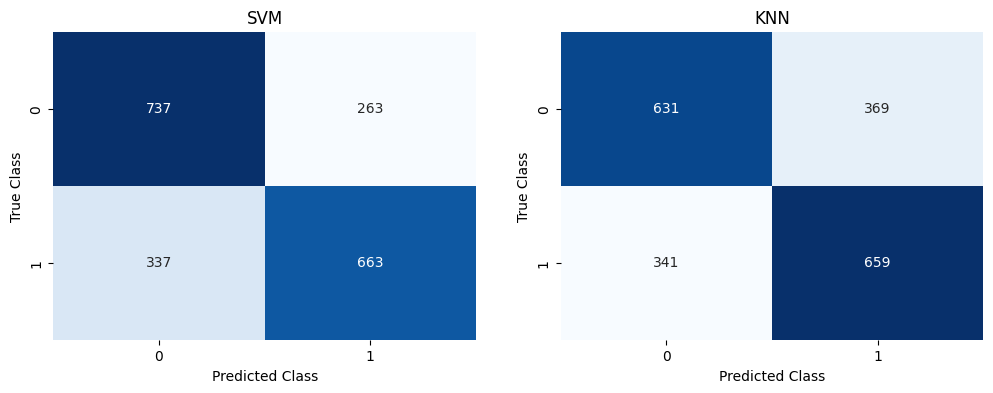

In [30]:
plot_cm(cm_svm, cm_knn)